<a href="https://colab.research.google.com/github/mdsiam135/research/blob/main/KNN(5_Labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# K-Nearest Neighbors (KNN) Classification Model for Agricultural Production Prediction
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

In [7]:
# Step 1: Load the datasets
print("Step 1: Loading datasets...")
try:
    train_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/train.csv')
    validation_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/validation.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/test.csv')
    print(f"Train data shape: {train_df.shape}")
    print(f"Validation data shape: {validation_df.shape}")
    print(f"Test data shape: {test_df.shape}")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please make sure train.csv, validation.csv, and test.csv files are in the current directory")
    exit()


Step 1: Loading datasets...
Train data shape: (3584, 84)
Validation data shape: (768, 84)
Test data shape: (768, 84)


In [8]:
# Step 2: Create 5-class labels based on quantiles for production column
print("\nStep 2: Creating 5-class quantile-based labels...")

def create_five_class_labels(data, column_name='Production (M.Ton)'):
    """Create very low, low, medium, high, very high labels based on quintiles"""
    if column_name not in data.columns:
        print(f"Error: '{column_name}' column not found in data")
        print(f"Available columns: {list(data.columns)}")
        return None

    # Handle any missing values
    production_data = data[column_name].dropna()

    # Calculate quintiles (20th, 40th, 60th, 80th percentiles)
    q20 = production_data.quantile(0.20)
    q40 = production_data.quantile(0.40)
    q60 = production_data.quantile(0.60)
    q80 = production_data.quantile(0.80)

    # Create labels
    labels = []
    for value in data[column_name]:
        if pd.isna(value):
            labels.append('medium')  # Default for missing values
        elif value <= q20:
            labels.append('very low')
        elif value <= q40:
            labels.append('low')
        elif value <= q60:
            labels.append('medium')
        elif value <= q80:
            labels.append('high')
        else:
            labels.append('very high')

    return labels, q20, q40, q60, q80

# Create labels for all datasets using training data quintiles
train_labels, q20, q40, q60, q80 = create_five_class_labels(train_df, 'Production (M.Ton)')
if train_labels is None:
    exit()

print(f"Quintile thresholds:")
print(f"Very Low: ≤{q20:.2f}")
print(f"Low: {q20:.2f}-{q40:.2f}")
print(f"Medium: {q40:.2f}-{q60:.2f}")
print(f"High: {q60:.2f}-{q80:.2f}")
print(f"Very High: >{q80:.2f}")

# Apply same thresholds to validation and test sets
def apply_five_class_labels(data, column_name, q20, q40, q60, q80):
    labels = []
    for value in data[column_name]:
        if pd.isna(value):
            labels.append('medium')  # Default for missing values
        elif value <= q20:
            labels.append('very low')
        elif value <= q40:
            labels.append('low')
        elif value <= q60:
            labels.append('medium')
        elif value <= q80:
            labels.append('high')
        else:
            labels.append('very high')
    return labels

validation_labels = apply_five_class_labels(validation_df, 'Production (M.Ton)', q20, q40, q60, q80)
test_labels = apply_five_class_labels(test_df, 'Production (M.Ton)', q20, q40, q60, q80)

# Add labels to dataframes
train_df['label'] = train_labels
validation_df['label'] = validation_labels
test_df['label'] = test_labels

print("\nLabel distribution in training set:")
print(train_df['label'].value_counts())


Step 2: Creating 5-class quantile-based labels...
Quintile thresholds:
Very Low: ≤550.20
Low: 550.20-1447.52
Medium: 1447.52-3064.52
High: 3064.52-6362.60
Very High: >6362.60

Label distribution in training set:
label
very high    717
very low     717
low          717
high         717
medium       716
Name: count, dtype: int64


In [9]:

# Step 3: Prepare features and labels
print("\nStep 3: Preparing features and labels...")

# Remove production column from features (since we're predicting based on it)
feature_columns = [col for col in train_df.columns if col not in ['Production (M.Ton)', 'label']]
print(f"Number of feature columns: {len(feature_columns)}")
print(f"Feature types:")
print(f"- Weather features: {len([col for col in feature_columns if any(weather in col.lower() for weather in ['temperature', 'soil', 'rain', 'humidity', 'precipitation', 'wetness'])])}")
print(f"- Crop features: {len([col for col in feature_columns if col.startswith('Crop_')])}")
print(f"- District features: {len([col for col in feature_columns if col.startswith('District_')])}")
print(f"- Other features: {len([col for col in feature_columns if not any(prefix in col for prefix in ['Crop_', 'District_']) and not any(weather in col.lower() for weather in ['temperature', 'soil', 'rain', 'humidity', 'precipitation', 'wetness'])])}")

X_train = train_df[feature_columns]
y_train = train_df['label']

X_val = validation_df[feature_columns]
y_val = validation_df['label']

X_test = test_df[feature_columns]
y_test = test_df['label']

# Handle any missing values in features
print(f"\nMissing values in training features: {X_train.isnull().sum().sum()}")
if X_train.isnull().sum().sum() > 0:
    print("Filling missing values with median for numerical columns...")
    for col in X_train.columns:
        if X_train[col].dtype in ['float64', 'int64']:
            median_val = X_train[col].median()
            X_train[col].fillna(median_val, inplace=True)
            X_val[col].fillna(median_val, inplace=True)
            X_test[col].fillna(median_val, inplace=True)
        else:
            mode_val = X_train[col].mode()[0] if len(X_train[col].mode()) > 0 else 0
            X_train[col].fillna(mode_val, inplace=True)
            X_val[col].fillna(mode_val, inplace=True)
            X_test[col].fillna(mode_val, inplace=True)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

print(f"Label mapping: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")



Step 3: Preparing features and labels...
Number of feature columns: 83
Feature types:
- Weather features: 9
- Crop features: 8
- District features: 64
- Other features: 2

Missing values in training features: 0
Label mapping: {'high': 0, 'low': 1, 'medium': 2, 'very high': 3, 'very low': 4}


In [10]:

# Step 4: Feature Scaling (Important for KNN)
print("\nStep 4: Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed.")



Step 4: Scaling features...
Feature scaling completed.


In [11]:
# Step 5: Find optimal K using validation curve (similar to epochs)
print("\nStep 5: Finding optimal K value...")

# Test different K values
k_range = range(1, 31, 2)  # Odd numbers from 1 to 29
train_scores = []
val_scores = []

print("Testing different K values...")
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean', weights='uniform')
    knn.fit(X_train_scaled, y_train_encoded)

    # Calculate scores
    train_pred = knn.predict(X_train_scaled)
    val_pred = knn.predict(X_val_scaled)

    train_acc = accuracy_score(y_train_encoded, train_pred)
    val_acc = accuracy_score(y_val_encoded, val_pred)

    train_scores.append(train_acc)
    val_scores.append(val_acc)

    if k % 5 == 1:  # Print every 5th iteration
        print(f"K={k}: Train Accuracy={train_acc:.4f}, Validation Accuracy={val_acc:.4f}")

# Find best K
best_k_idx = np.argmax(val_scores)
best_k = k_range[best_k_idx]
print(f"\nBest K value: {best_k} with validation accuracy: {val_scores[best_k_idx]:.4f}")



Step 5: Finding optimal K value...
Testing different K values...
K=1: Train Accuracy=1.0000, Validation Accuracy=0.8229
K=11: Train Accuracy=0.8298, Validation Accuracy=0.7852
K=21: Train Accuracy=0.6989, Validation Accuracy=0.6107

Best K value: 1 with validation accuracy: 0.8229


In [12]:
# Step 6: Train final model with best K
print(f"\nStep 6: Training final KNN model with K={best_k}...")

final_knn = KNeighborsClassifier(
    n_neighbors=best_k,
    metric='euclidean',
    weights='uniform',
    algorithm='auto'
)

final_knn.fit(X_train_scaled, y_train_encoded)
print("Model training completed.")



Step 6: Training final KNN model with K=1...
Model training completed.


In [13]:


# Step 7: Make predictions
print("\nStep 7: Making predictions...")

train_pred = final_knn.predict(X_train_scaled)
val_pred = final_knn.predict(X_val_scaled)
test_pred = final_knn.predict(X_test_scaled)

# Get prediction probabilities
train_pred_proba = final_knn.predict_proba(X_train_scaled)
val_pred_proba = final_knn.predict_proba(X_val_scaled)
test_pred_proba = final_knn.predict_proba(X_test_scaled)



Step 7: Making predictions...


In [14]:
# Step 8: Calculate metrics
print("\nStep 8: Calculating evaluation metrics...")

def calculate_metrics(y_true, y_pred, dataset_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

    print(f"\n{dataset_name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro
    }

# Calculate metrics for all datasets
train_metrics = calculate_metrics(y_train_encoded, train_pred, "Training")
val_metrics = calculate_metrics(y_val_encoded, val_pred, "Validation")
test_metrics = calculate_metrics(y_test_encoded, test_pred, "Testing")



Step 8: Calculating evaluation metrics...

Training Metrics:
Accuracy: 1.0000
Precision (Weighted): 1.0000
Recall (Weighted): 1.0000
F1 Score (Weighted): 1.0000
F1 Score (Macro): 1.0000

Validation Metrics:
Accuracy: 0.8229
Precision (Weighted): 0.8231
Recall (Weighted): 0.8229
F1 Score (Weighted): 0.8220
F1 Score (Macro): 0.8213

Testing Metrics:
Accuracy: 0.8047
Precision (Weighted): 0.8051
Recall (Weighted): 0.8047
F1 Score (Weighted): 0.8046
F1 Score (Macro): 0.8025



Step 9: Plotting K-value optimization curve...


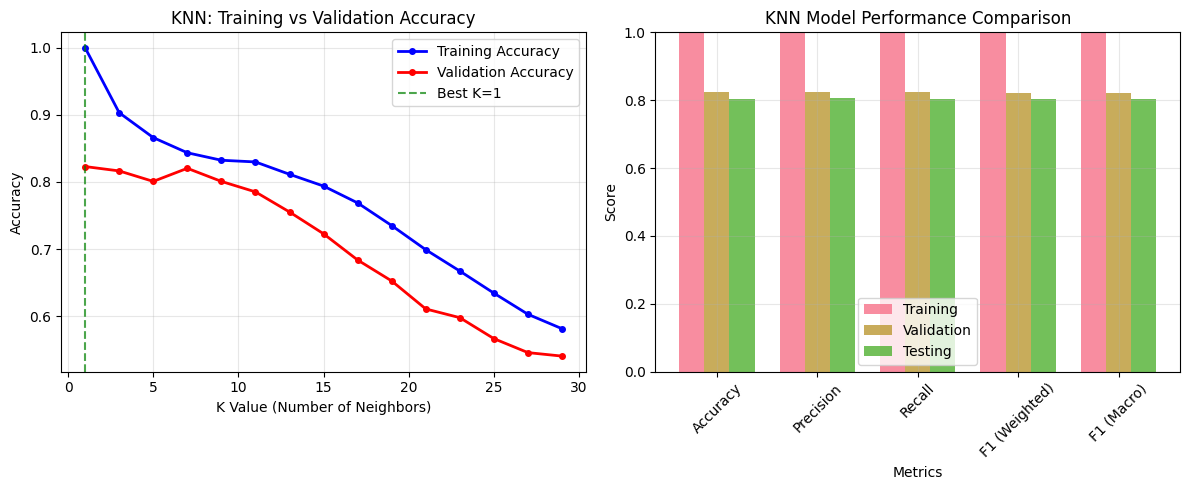

In [15]:
# Step 9: Plot K-value optimization curve (similar to epoch curves)
print("\nStep 9: Plotting K-value optimization curve...")

plt.figure(figsize=(12, 5))

# Plot 1: K-value optimization curve
plt.subplot(1, 2, 1)
plt.plot(k_range, train_scores, 'b-o', label='Training Accuracy', linewidth=2, markersize=4)
plt.plot(k_range, val_scores, 'r-o', label='Validation Accuracy', linewidth=2, markersize=4)
plt.axvline(x=best_k, color='green', linestyle='--', alpha=0.7, label=f'Best K={best_k}')
plt.xlabel('K Value (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.title('KNN: Training vs Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Metrics comparison
plt.subplot(1, 2, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 (Weighted)', 'F1 (Macro)']
train_values = [train_metrics['accuracy'], train_metrics['precision'],
                train_metrics['recall'], train_metrics['f1_weighted'], train_metrics['f1_macro']]
val_values = [val_metrics['accuracy'], val_metrics['precision'],
              val_metrics['recall'], val_metrics['f1_weighted'], val_metrics['f1_macro']]
test_values = [test_metrics['accuracy'], test_metrics['precision'],
               test_metrics['recall'], test_metrics['f1_weighted'], test_metrics['f1_macro']]

x = np.arange(len(metrics_names))
width = 0.25

plt.bar(x - width, train_values, width, label='Training', alpha=0.8)
plt.bar(x, val_values, width, label='Validation', alpha=0.8)
plt.bar(x + width, test_values, width, label='Testing', alpha=0.8)

plt.title('KNN Model Performance Comparison')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.xticks(x, metrics_names, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


Step 10: Plotting confusion matrices...


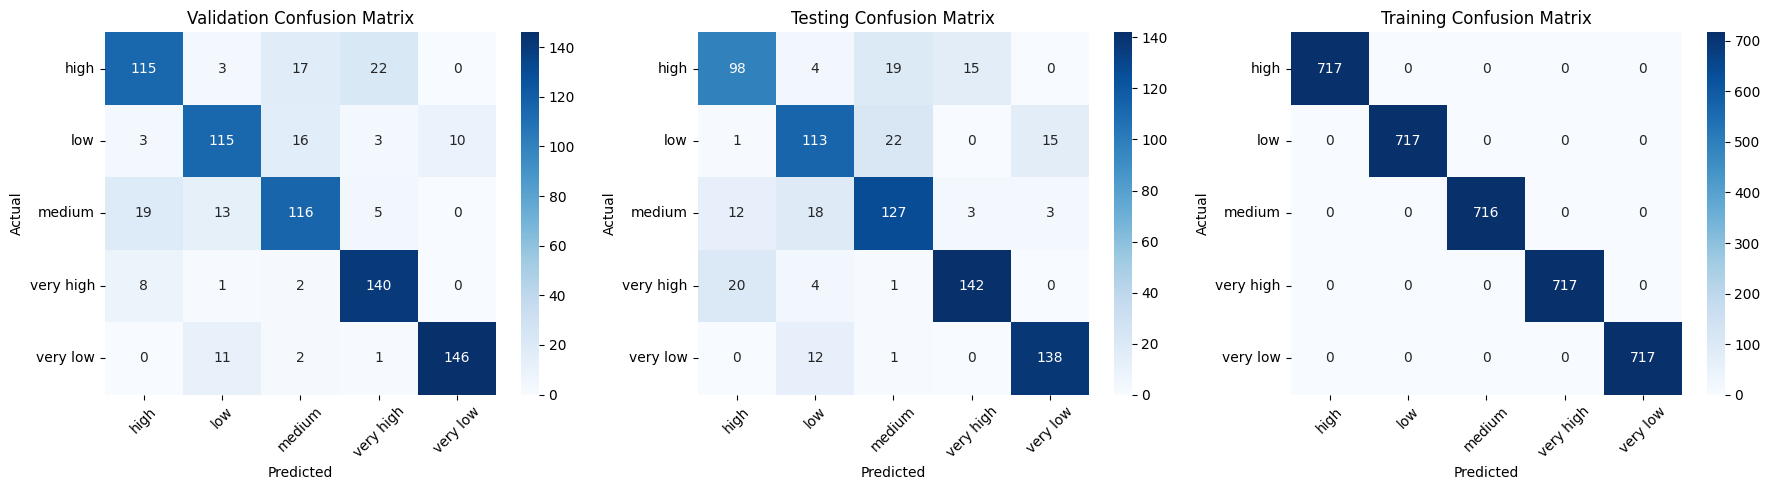

In [16]:
# Step 10: Plot confusion matrices
print("\nStep 10: Plotting confusion matrices...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
class_names = label_encoder.classes_

datasets = [
    (y_val_encoded, val_pred, "Validation"),
    (y_test_encoded, test_pred, "Testing"),
    (y_train_encoded, train_pred, "Training")
]

for i, (y_true, y_pred, title) in enumerate(datasets):
    cm = confusion_matrix(y_true, y_pred)

    # Create heatmap
    im = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                     xticklabels=class_names, yticklabels=class_names, ax=axes[i])
    axes[i].set_title(f'{title} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

    # Rotate labels for better readability
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()



Step 11: Distance analysis...
Average distance to 1 nearest neighbors:
Min: 0.5077
Max: 4.2564
Mean: 1.7777
Std: 0.6418


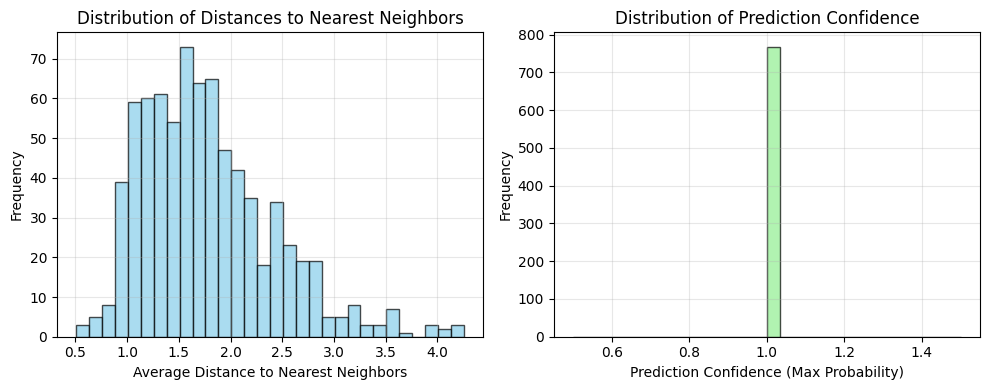

In [17]:
# Step 11: Additional analysis - Distance analysis
print("\nStep 11: Distance analysis...")

# Calculate distances to nearest neighbors for validation set
distances, indices = final_knn.kneighbors(X_val_scaled, n_neighbors=best_k)
avg_distances = np.mean(distances, axis=1)

print(f"Average distance to {best_k} nearest neighbors:")
print(f"Min: {np.min(avg_distances):.4f}")
print(f"Max: {np.max(avg_distances):.4f}")
print(f"Mean: {np.mean(avg_distances):.4f}")
print(f"Std: {np.std(avg_distances):.4f}")

# Plot distance distribution
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(avg_distances, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Average Distance to Nearest Neighbors')
plt.ylabel('Frequency')
plt.title('Distribution of Distances to Nearest Neighbors')
plt.grid(True, alpha=0.3)

# Plot prediction confidence (max probability)
plt.subplot(1, 2, 2)
confidence_scores = np.max(val_pred_proba, axis=1)
plt.hist(confidence_scores, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
plt.xlabel('Prediction Confidence (Max Probability)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Confidence')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [18]:
# Step 12: Detailed Classification Reports
print("\nStep 12: Detailed Classification Reports...")

print("\nValidation Set Classification Report:")
print(classification_report(y_val_encoded, val_pred, target_names=class_names))

print("\nTest Set Classification Report:")
print(classification_report(y_test_encoded, test_pred, target_names=class_names))



Step 12: Detailed Classification Reports...

Validation Set Classification Report:
              precision    recall  f1-score   support

        high       0.79      0.73      0.76       157
         low       0.80      0.78      0.79       147
      medium       0.76      0.76      0.76       153
   very high       0.82      0.93      0.87       151
    very low       0.94      0.91      0.92       160

    accuracy                           0.82       768
   macro avg       0.82      0.82      0.82       768
weighted avg       0.82      0.82      0.82       768


Test Set Classification Report:
              precision    recall  f1-score   support

        high       0.75      0.72      0.73       136
         low       0.75      0.75      0.75       151
      medium       0.75      0.78      0.76       163
   very high       0.89      0.85      0.87       167
    very low       0.88      0.91      0.90       151

    accuracy                           0.80       768
   macro avg  


Step 13: Feature importance analysis...


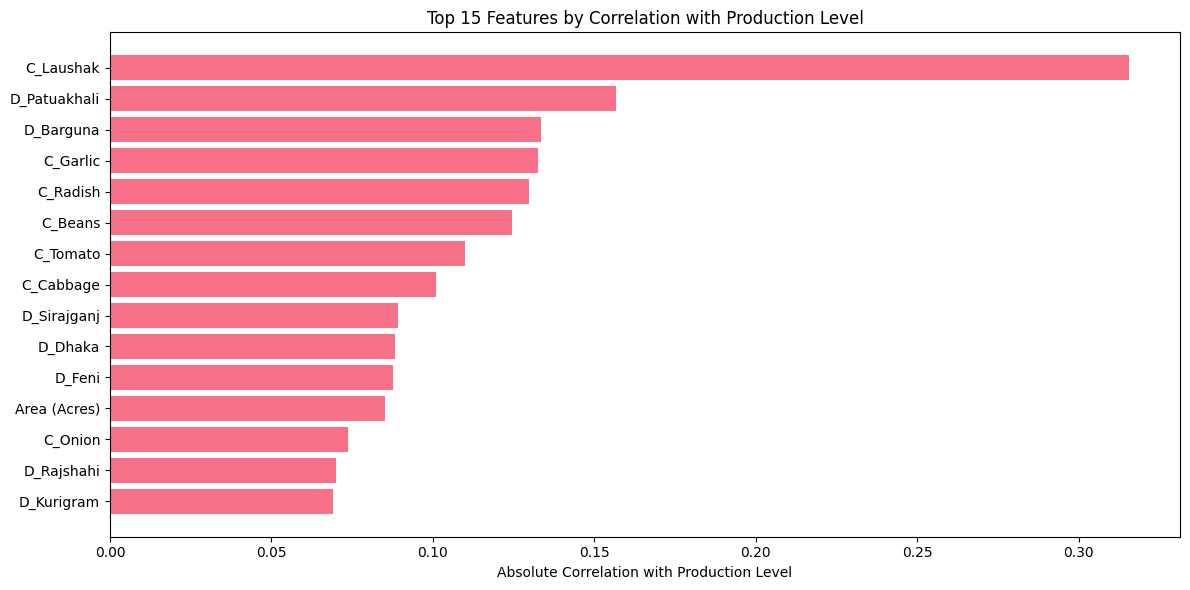

In [21]:

# Step 13: Feature importance analysis (based on correlation with target)
print("\nStep 13: Feature importance analysis...")

# Calculate correlation between features and encoded target
correlations = []
for col in X_train.columns:
    corr = np.corrcoef(X_train[col], y_train_encoded)[0, 1]
    if not np.isnan(corr):
        correlations.append((col, abs(corr)))

# Sort by absolute correlation
correlations.sort(key=lambda x: x[1], reverse=True)


# Plot top features
plt.figure(figsize=(12, 6))
top_features = correlations[:15]
features = [f[0] for f in top_features]
corr_values = [f[1] for f in top_features]

plt.barh(range(len(features)), corr_values)
plt.yticks(range(len(features)), [f.replace('District_', 'D_').replace('Crop_', 'C_') for f in features])
plt.xlabel('Absolute Correlation with Production Level')
plt.title('Top 15 Features by Correlation with Production Level')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [22]:


# Summary
print("\n" + "="*70)
print("FINAL SUMMARY - KNN CLASSIFICATION MODEL")
print("="*70)
print(f"Best K value: {best_k}")
print(f"Number of classes: 5 (very low, low, medium, high, very high)")
print(f"Number of features: {len(feature_columns)}")

print(f"\nFinal Macro F1 Scores:")
print(f"Training: {train_metrics['f1_macro']:.4f}")
print(f"Validation: {val_metrics['f1_macro']:.4f}")
print(f"Testing: {test_metrics['f1_macro']:.4f}")

print(f"\nFinal Accuracy Scores:")
print(f"Training: {train_metrics['accuracy']:.4f}")
print(f"Validation: {val_metrics['accuracy']:.4f}")
print(f"Testing: {test_metrics['accuracy']:.4f}")

print(f"\nModel Characteristics:")
print(f"- Algorithm: K-Nearest Neighbors")
print(f"- Distance Metric: Euclidean")
print(f"- Weighting: Uniform")
print(f"- Feature Scaling: StandardScaler")

print("\nKNN model training and evaluation completed successfully!")


FINAL SUMMARY - KNN CLASSIFICATION MODEL
Best K value: 1
Number of classes: 5 (very low, low, medium, high, very high)
Number of features: 83

Final Macro F1 Scores:
Training: 1.0000
Validation: 0.8213
Testing: 0.8025

Final Accuracy Scores:
Training: 1.0000
Validation: 0.8229
Testing: 0.8047

Model Characteristics:
- Algorithm: K-Nearest Neighbors
- Distance Metric: Euclidean
- Weighting: Uniform
- Feature Scaling: StandardScaler

KNN model training and evaluation completed successfully!
